In [1]:
from utils import set_working_directory_up_two_levels
set_working_directory_up_two_levels()

# Pre-training results


In [182]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
import toml
import os
import glob

# from presentation.pipelines.steps.load_data import build_loader
# from presentation.pipelines.steps.model_design import load_pt_model

from src.utils import tensorboard_logs

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [225]:
TAG = 'n_samples' # should match the name of the hyperparameter in config.toml 

model_paths = glob.glob(os.path.join('./presentation/results/nsamples/', '*', 'pretraining'))

sorted_path = np.array(model_paths.copy())
index_value = []
for path in model_paths:
    with open(os.path.join(path, 'config.toml'), 'r') as file:
        conf = toml.load(file)
        if TAG == 'n_samples':
            index_value.append(int(conf['data'].split('/')[-3]))
        else:
            index_value.append(conf[TAG])

index_value = np.array(index_value)
index_value = np.argsort(index_value)
sorted_path = list(sorted_path[index_value])
# sorted_path = sorted_path[:-1]

## Learning curves

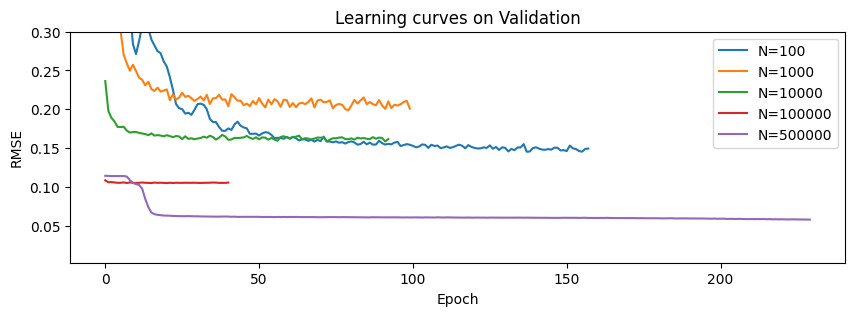

In [226]:
plt.figure(figsize=(10,3))
for path in sorted_path:
    train_metrics, val_metrics = tensorboard_logs(path)
    if TAG == 'n_samples':
        a = int(train_metrics['data'].iloc[0].split('/')[-3])
        label = r'N={:.0f}'.format(a)
    if TAG == 'temperature':
        label = r'$\tau$={:.2f}'.format(train_metrics['temperature'].iloc[0])
    if TAG == 'm_alpha':
        val = train_metrics['m_alpha'].iloc[0]
        if float(val) == -1e9:
            label = r'$\alpha$=$-\infty$'
        else:
            label = r'$\alpha$={:.0f}'.format(val)
            
    plt.plot(val_metrics['step'], val_metrics['loss'], label=label)

plt.legend(bbox_to_anchor=(1., 1.0))
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.title('Learning curves on Validation')
if TAG == 'n_samples':
    plt.ylim(2e-3, 0.3)
if TAG == 'm_alpha':
    plt.ylim(6.3e-2, 6.8e-2)
if TAG == 'temperature':
    plt.ylim(5e-2, 7e-2)

plt.show()


### Number of samples

In [227]:
x_plot, y1_plot, y2_plot = [], [], []

for logs in sorted_path:
    train_metrics, val_metrics = tensorboard_logs(logs)
    row = val_metrics[val_metrics['rmse'].astype('float').values == val_metrics['rmse'].min()]
    
    y1_plot.append(float(row['rmse'].values[0]))
    y2_plot.append(float(row['rsquare'].values[0]))

    if TAG == 'n_samples':
        value = int(row['data'].values[0].split('/')[-3])
    if TAG == 'm_alpha':
        value = row['m_alpha'].iloc[0]
    if TAG == 'temperature':
        value = row['temperature'].iloc[0]
    x_plot.append(value)

In [228]:
x_plot  = np.array(x_plot)
y1_plot = np.array(y1_plot)
y2_plot = np.array(y2_plot)
test_metrics_pt = []
for i, path in enumerate(sorted_path):
    curr = os.path.join(path, 'results.csv')
    partial_df = pd.read_csv(curr)
    if TAG == 'n_samples':
        partial_df['n_samples'] = x_plot[i]
    test_metrics_pt.append(partial_df)

test_metrics_pt = pd.concat(test_metrics_pt)  

In [229]:
df = pd.DataFrame()
df[TAG] = x_plot
df['val_rmse'] = y1_plot
df['val_r2'] = y2_plot
df_1 = test_metrics_pt[[TAG, 'test_mse', 'test_r2']]
df_2 = pd.merge(df, df_1, on=TAG)
df_2 = df_2.round(3)
df_2

,n_samples,val_rmse,val_r2,test_mse,test_r2
0,100,0.145,-0.121,0.171,-0.560
1,1000,0.198,-0.032,0.155,-0.068
2,10000,0.158,-0.016,0.153,-0.020
3,100000,0.105,-0.006,0.153,-0.008
4,500000,0.058,0.743,0.078,0.716


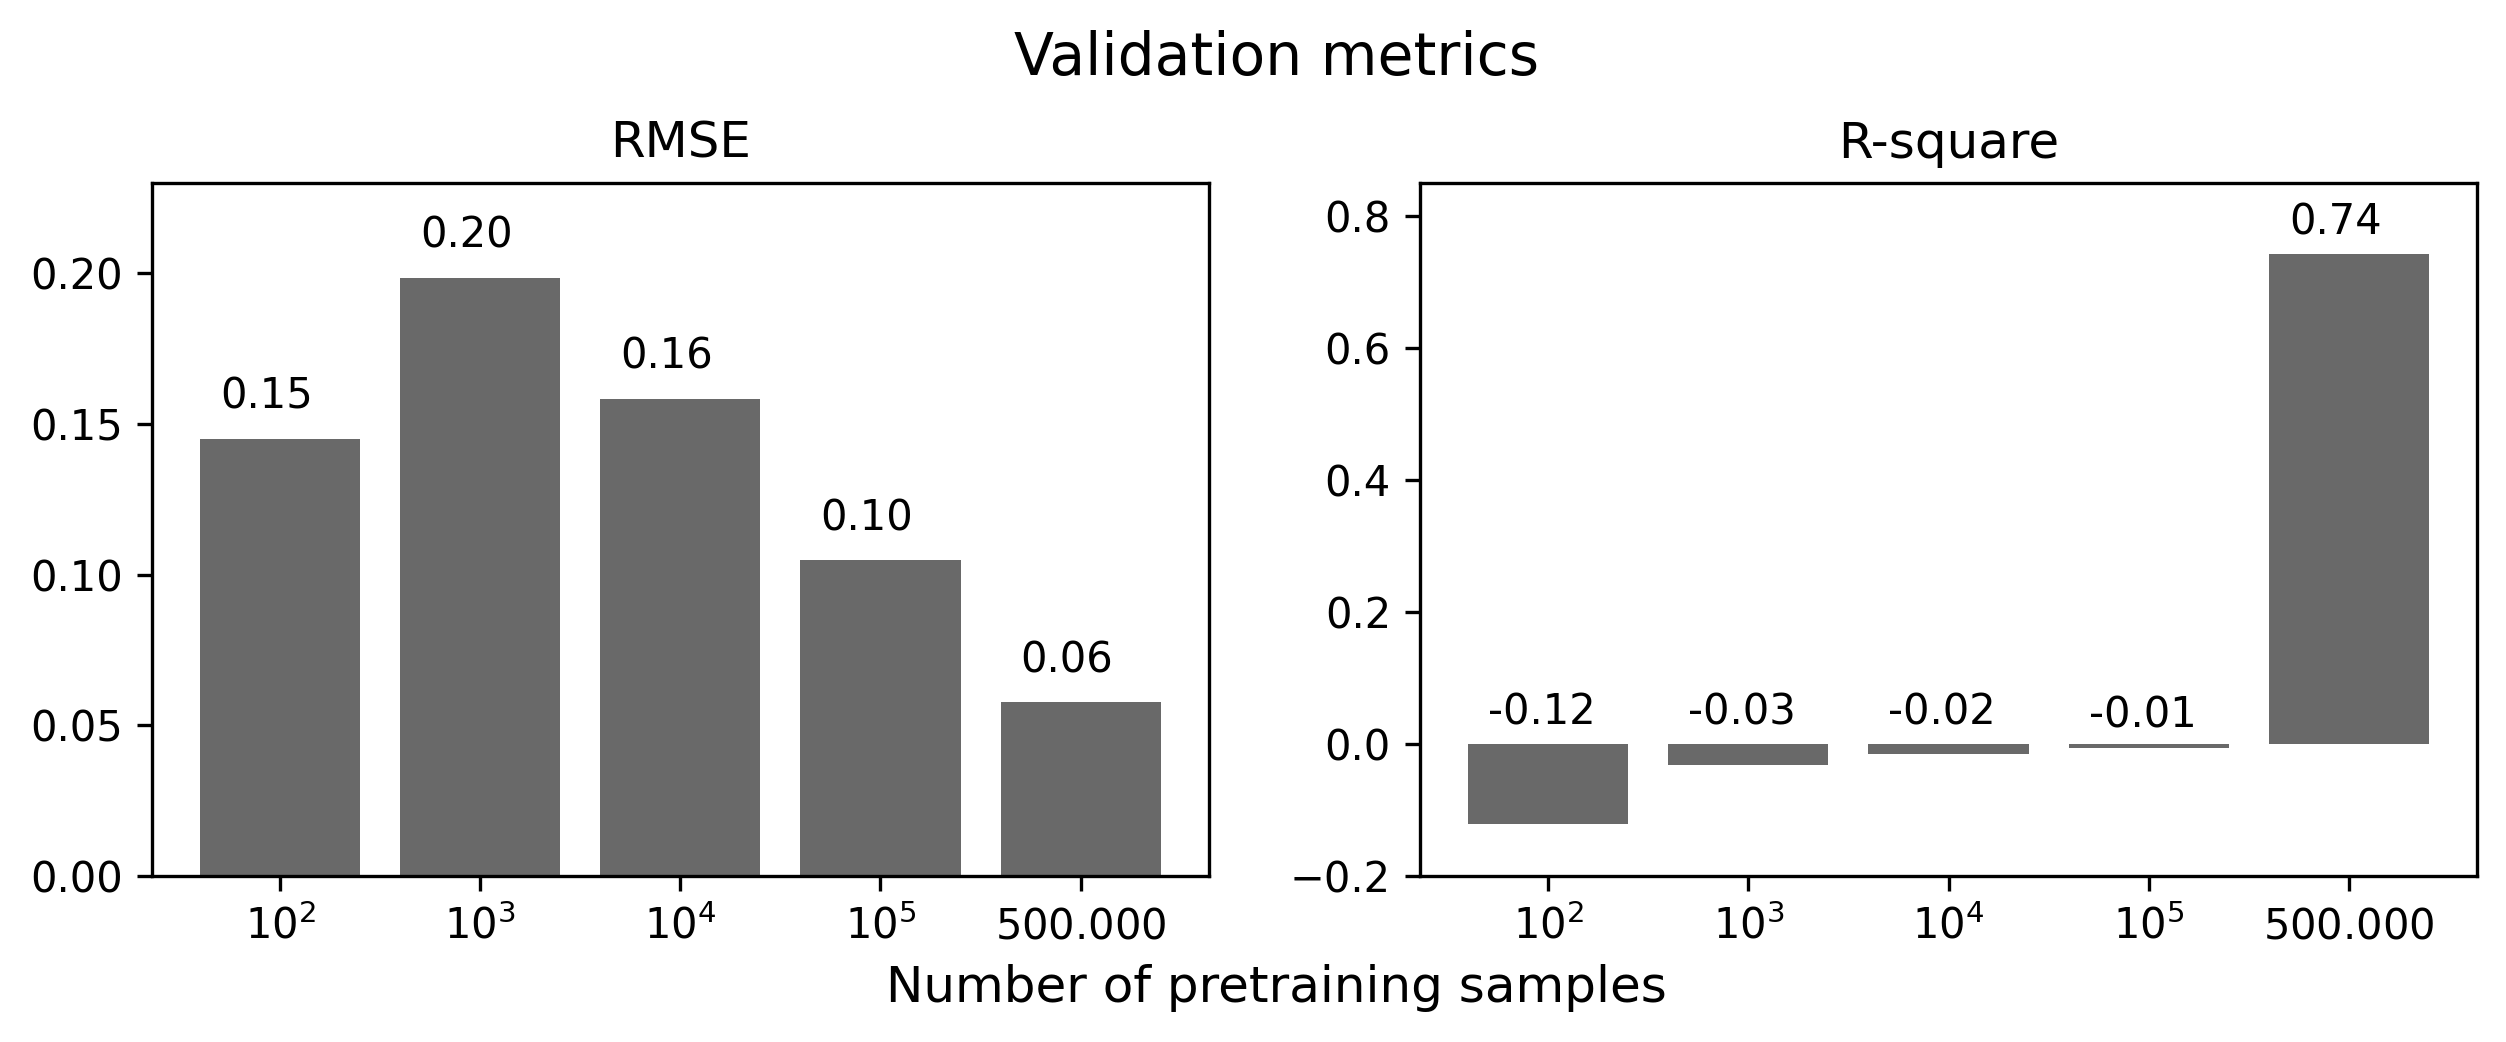

In [230]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(10, 3))
xticks = range(len(x_plot))
if TAG == 'temperature':
    x_plot_ = [0.5, 1, 1.5, 2, 2.5]
if TAG == 'n_samples':
    x_plot_ = ['$10^2$', '$10^3$', '$10^4$', '$10^5$', '$500.000$']
if TAG == 'm_alpha':
    x_plot_ = ['$-\infty$', '$-10^3$', '$-10^2$', '$-10$', '$-1$', '$0$', '$1$']

axes[0].bar(xticks, y1_plot, color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot_, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.23)
for i, value in enumerate(y1_plot):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, y2_plot, color='dimgray')
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(x_plot_, rotation=0)
for i, value in enumerate(y2_plot):
    if i < 3 and TAG == 'n_samples':
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))

axes[1].set_title('R-square')
if TAG == 'n_samples':
    axes[1].set_ylim(-0.2, 0.85)
else:
    axes[1].set_ylim(-0., 0.85)

fig.text(0.5, 1., 'Validation metrics', ha='center', fontsize=14)
if TAG == 'temperature':
    fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
if TAG == 'm_alpha':
    fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
if TAG == 'n_samples':
    fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
fig.savefig('./presentation/figures/{}_val.pdf'.format(TAG), format='pdf', bbox_inches='tight')  
plt.show()

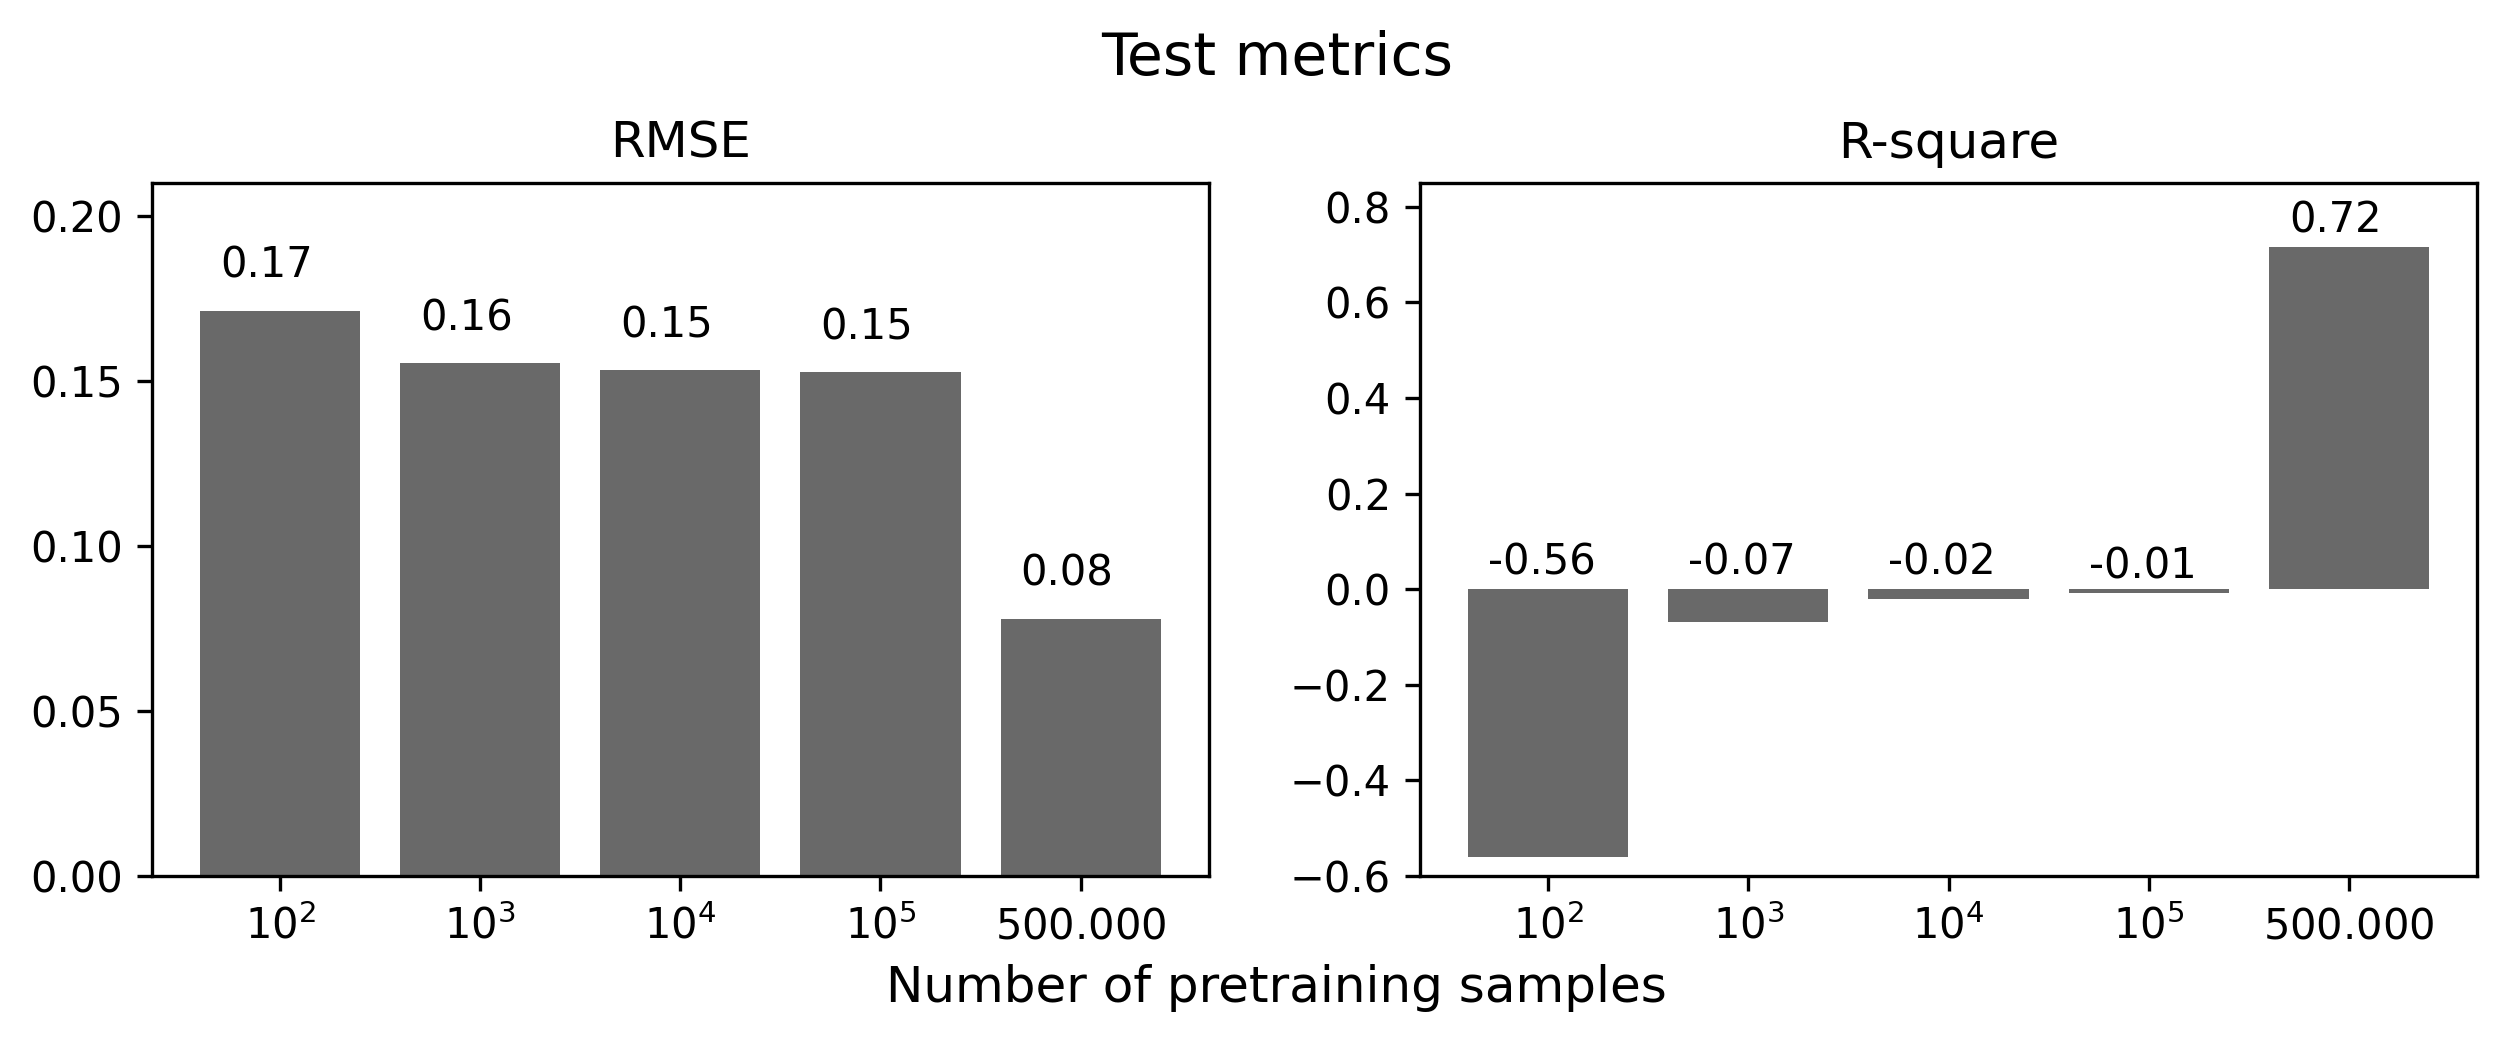

In [231]:
fig, axes = plt.subplots(1, 2, dpi=300, figsize=(10, 3))

axes[0].bar(xticks, test_metrics_pt['test_mse'], color='dimgray')
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(x_plot_, rotation=0)
axes[0].set_title('RMSE')
axes[0].set_ylim(0, 0.21)

for i, value in enumerate(test_metrics_pt['test_mse']):
    axes[0].text(i-.3, value+0.01, '{:.2f}'.format(value))

axes[1].bar(xticks, test_metrics_pt['test_r2'], color='dimgray')
axes[1].set_xticks(xticks)

axes[1].set_xticklabels(x_plot_, rotation=0)

for i, value in enumerate(test_metrics_pt['test_r2']):
    if i < 3 and TAG == 'n_samples':
        axes[1].text(i-.3, 0.03, '{:.2f}'.format(value))
    else:
        axes[1].text(i-.3, value+0.03, '{:.2f}'.format(value))
    
axes[1].set_title('R-square')
if TAG == 'n_samples':
    axes[1].set_ylim(-0.6, 0.85)
else:
    axes[1].set_ylim(-0., 0.85)

fig.text(0.5, 1., 'Test metrics', ha='center', fontsize=14)
if TAG == 'temperature':
    fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
if TAG == 'm_alpha':
    fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
if TAG == 'n_samples':
    fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
fig.savefig('./presentation/figures/{}_test.pdf'.format(TAG), format='pdf', bbox_inches='tight')  
plt.show() 

### Classification

In [232]:
from presentation.pipelines.pipeline_0.utils import classification_metrics

In [233]:
test_metrics = []
for i, root in enumerate(sorted_path):
    curr = classification_metrics(os.path.join(root, '..'), spc_list=[20, 100, 500])
    if TAG =='n_samples':
        curr['n_samples'] = [x_plot_[i]]*curr.shape[0]
    test_metrics.append(curr)
test_metrics = pd.concat(test_metrics)

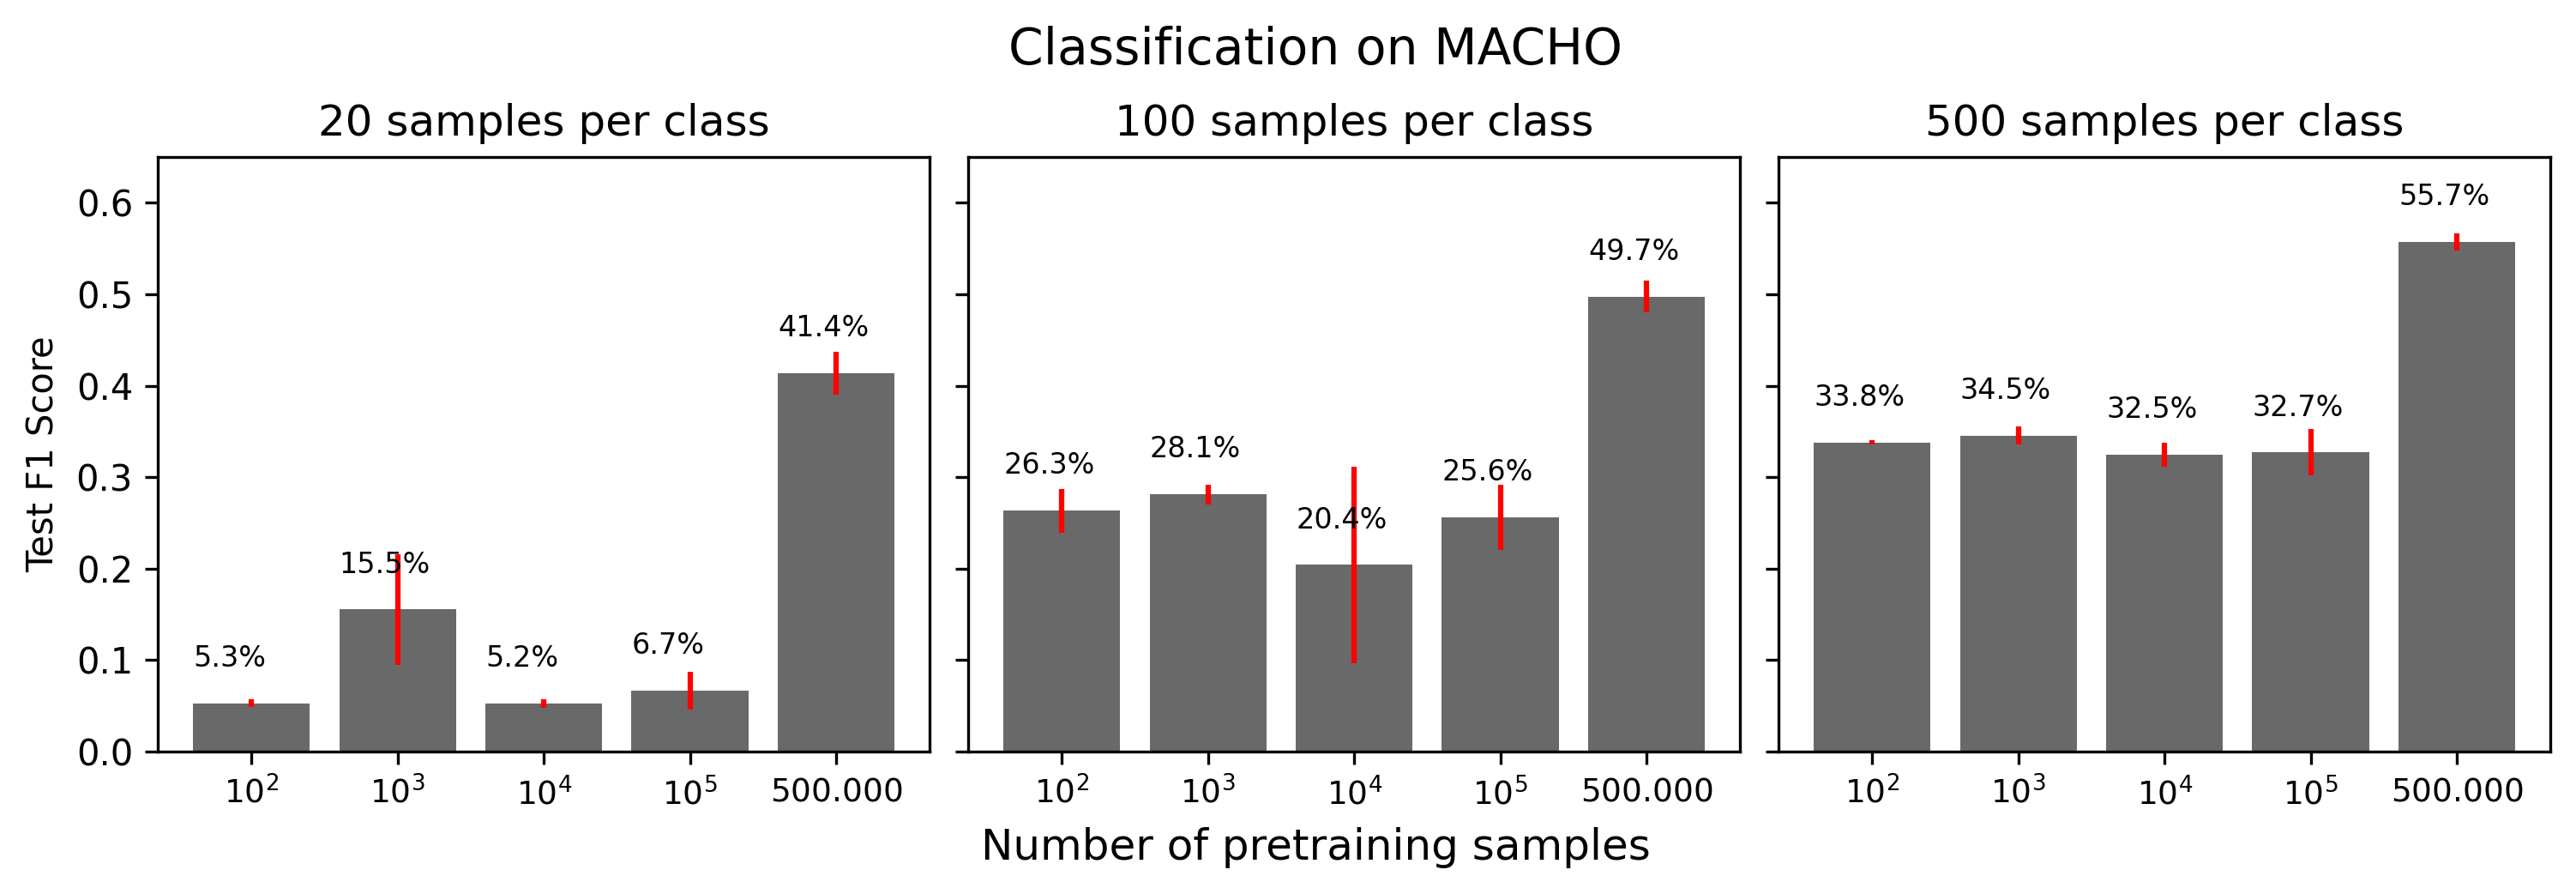

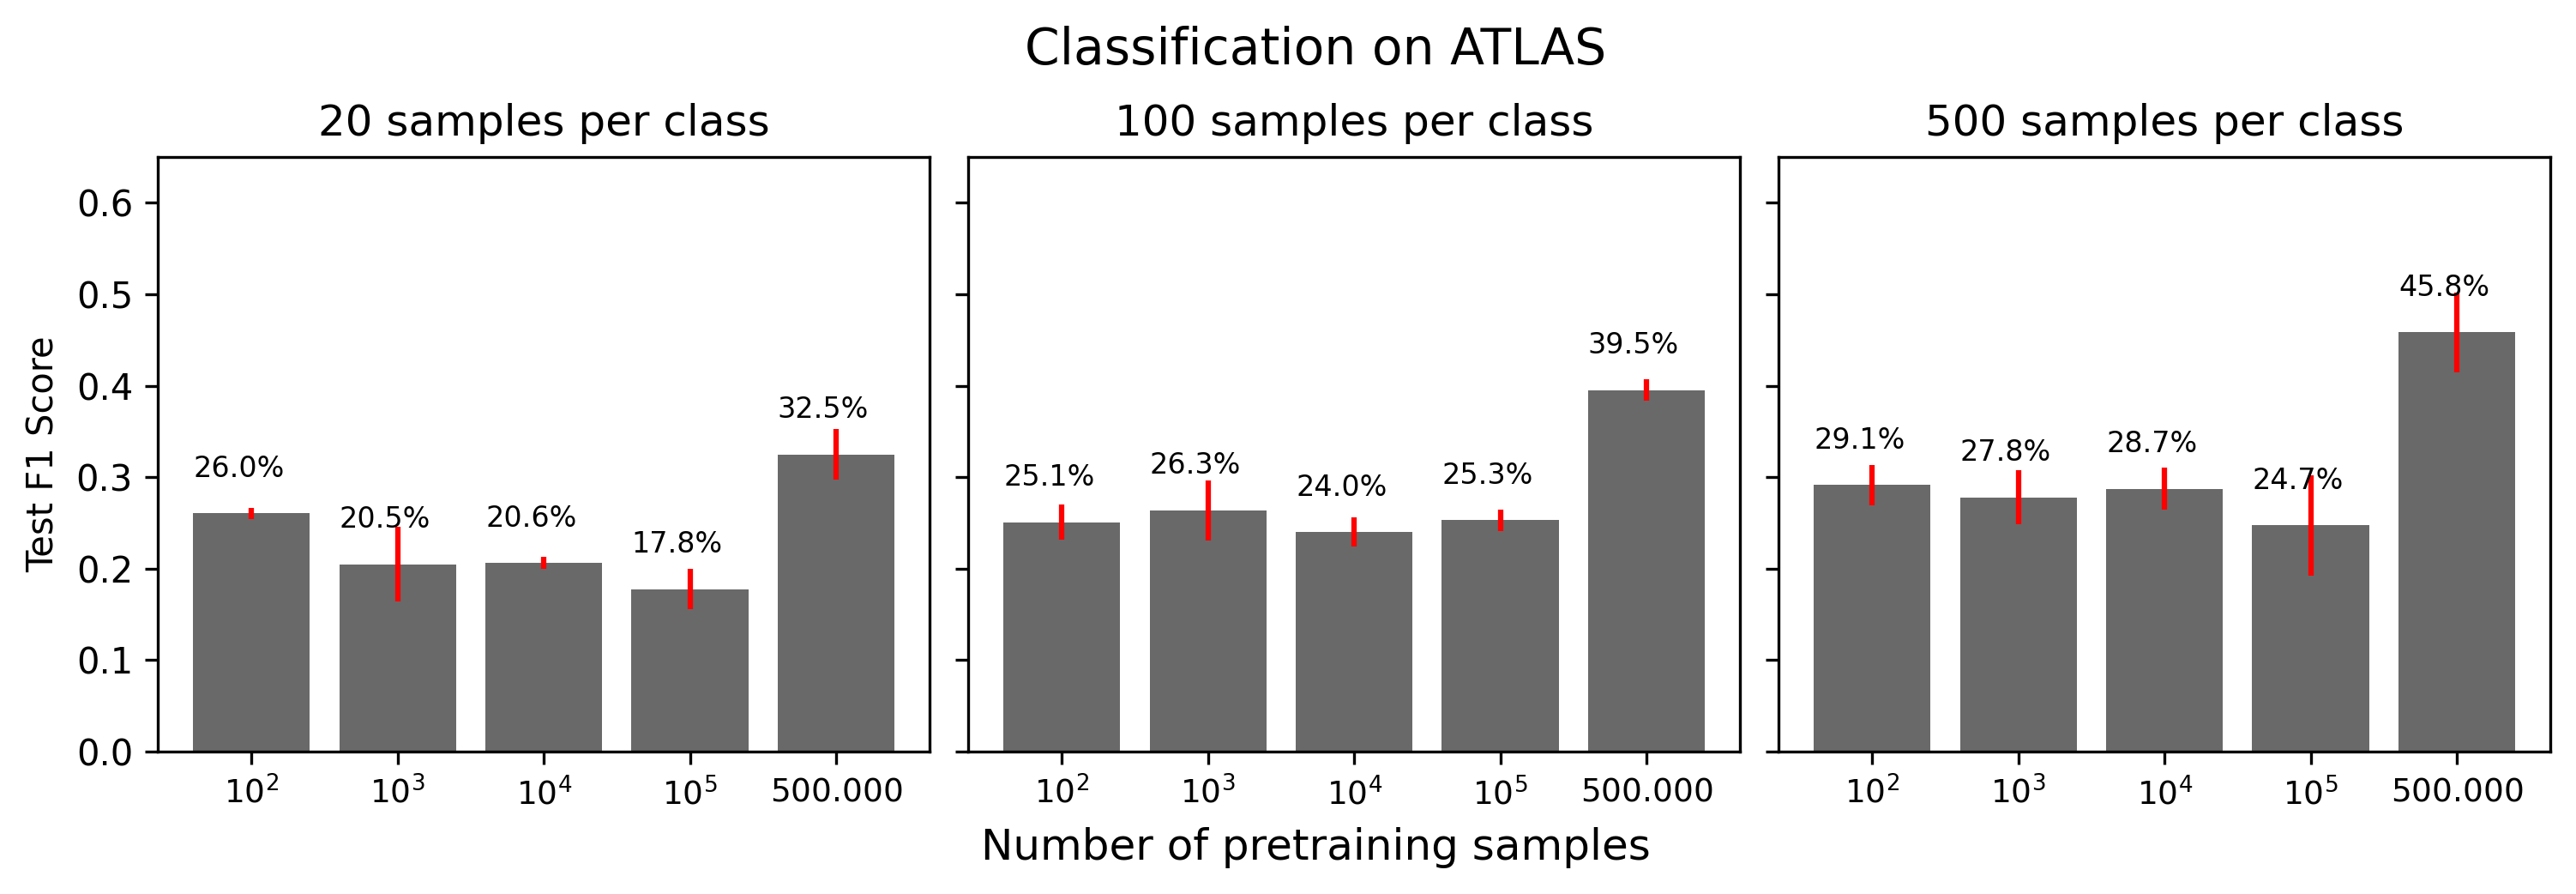

In [234]:
for group0, df0 in test_metrics.groupby('data'):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True, dpi=300, gridspec_kw={'wspace': 0.05})
    for k, (group1, df1) in enumerate(df0.groupby('spc')):
        df1 = df1.sort_values(TAG)

        xticks = range(len(x_plot_))
        
        yv = df1['mean'].values
        xv = list(xticks)
        ye = df1['std'].values
        

        axes[k].bar(xv, yv, yerr=ye, color='dimgray', ecolor='red')
        axes[k].set_xticks(xticks)
        axes[k].set_xticklabels(x_plot_, rotation=0, fontsize=9)
        axes[k].set_title('{} samples per class'.format(group1))
        if TAG == 'n_samples':
            axes[k].set_ylim(0., 0.65)
        else:
            axes[k].set_ylim(0.1, 0.8)
            
        for i, value in enumerate(df1['mean']):
            axes[k].text(i-0.4, value+0.04, '{:.1f}%'.format(value*100) ,fontsize=8, rotation=0)
    
    axes[0].set_ylabel('Test F1 Score', fontsize=10)
    
    if group0 == 'alcock': title = 'Classification on MACHO'
    if group0 == 'atlas': title = 'Classification on ATLAS'
        
    fig.text(0.5, 1., title, ha='center', fontsize=14)
    if TAG == 'temperature':
        fig.text(0.5, -0.03, r'Temperature ($\tau$)', ha='center', fontsize=12)
    if TAG == 'm_alpha':
        fig.text(0.5, -0.03, r'Soft-masking scaling term ($\alpha$)', ha='center', fontsize=12)
    if TAG == 'n_samples':
        fig.text(0.5, -0.03, r'Number of pretraining samples', ha='center', fontsize=12)
    fig.savefig('./presentation/figures/clf_vs_{}_{}.pdf'.format(TAG, group0), format='pdf', bbox_inches='tight')  